# Preparing YouTube Faces for Training

In this notebook we will be working with the preprocessed version of the YouTube Faces dataset, available on Kaggle: https://www.kaggle.com/selfishgene/youtube-faces-with-facial-keypoints#youtube_faces_with_keypoints_large.csv

Particularly, we will consider only the folders marked as "large" and will prepare the data ready for training in 3 steps:
1. Save each image as a PNG on disk, and the corresponding bounding boxes and landmarks in NPY files. The 3 types of data will be placed in separate folders.
2. Resize each image created in the previous step to a given size and update the bounding box and landmark files accordingly.
3. Split the data into train, validation and test sets. Argument the chosen splitting procedure.

*Prerequisites:*
It is assumed that the data was downloaded from Kaggle (about 10GB) and extracted to your computer.

Let's load the required packages first and define constant variables to be used later.

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import tqdm
import random

%matplotlib inline

PATH_IN = 'D:/databases/YouTubeFaces'          # input path where you extracted the downloaded ZIP file
PATH_OUT = './'                                # output path where to save the data (images, bounding boxes, landmarks)
HEIGHT, WIDTH = 100, 100                       # size of training images (modify to your needs)
MAX_IM_NR = 155560                             # maximum number of input images (according to Kaggle description)

## 0 - Checking the Data

The dataset contains Youtube videos of celebrities, detected bounding boxes for the face and facial landmark coordinates. The frames of a video and corresponding annotations are saved in an NPZ file (containing a dictionary).

Before converting the dataset, let's see first the contents of an arbitrary NPZ file.

In [2]:
npz_in = os.path.join(PATH_IN, 'youtube_faces_with_keypoints_large_1', 'Aidan_Quinn_2.npz')

x = np.load(npz_in)
print('Fields in NPZ file:', x.files)
print('Video size:       ', x['colorImages'].shape)
print('Bounding box size:', x['boundingBox'].shape)
print('Landmarks shape:  ', x['landmarks2D'].shape)

Fields in NPZ file: ['boundingBox', 'landmarks3D', 'colorImages', 'landmarks2D']
Video size:        (299, 237, 3, 50)
Bounding box size: (4, 2, 50)
Landmarks shape:   (68, 2, 50)


We may also want to visualize the annotations on a give image. Let's write a method for that.

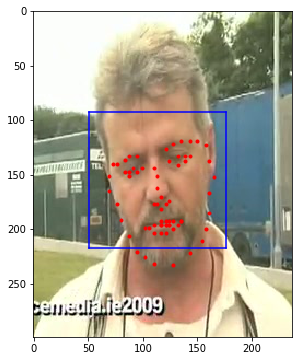

In [3]:
def visualize_BB_landmarks(im, bounding_box, landmarks2D):
    '''
    Visualizes the detected bounding box and landmarks on the given image.
    '''
    fig, ax = plt.subplots(1)
    fig.set_size_inches(9, 6)
    ax.imshow(im)
    # show bounding box
    ax.plot([bounding_box[0, 0], bounding_box[1, 0]], [bounding_box[0, 1], bounding_box[1, 1]], 'b')
    ax.plot([bounding_box[1, 0], bounding_box[3, 0]], [bounding_box[1, 1], bounding_box[3, 1]], 'b')
    ax.plot([bounding_box[3, 0], bounding_box[2, 0]], [bounding_box[3, 1], bounding_box[2, 1]], 'b')
    ax.plot([bounding_box[2, 0], bounding_box[0, 0]], [bounding_box[2, 1], bounding_box[0, 1]], 'b')
    
    # show landmarks
    for i in range(landmarks2D.shape[0]):
        ax.plot(landmarks2D[i, 0], landmarks2D[i, 1], 'r.')
    return

i = 10 # index of frame in video. Note: x was defined in the previous code-cell.
visualize_BB_landmarks(x['colorImages'][:, :, :, i],
                      x['boundingBox'][:, :, i],
                      x['landmarks2D'][:, :, i])

## 1 - Save Images and Annotations

Let's solve now the first task of saving the images and annotations to disk. First the output directories are created. Also meta-information will be collected for later use about image sizes, video ID's, person names, image size, input path, sequence number of image/data (for convenience). So let's create a dataframe for that as well. We also define utility functions to create the directory structure, save/load the data (image, bounding box and landmarks) to/from this structure.

The directory structure will be as follows:  
<pre>
[dname]/images/image[i].png  
               ...  
       /bounding_boxes/image[i].npy
                       ...  
       /landmarks2D/image[i].npy
                    ...               
</pre>


In [4]:
def create_dir(dir_name):
    '''
    Checks if a directory exists, and if not thet it creates it.
    '''
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)
    return

def create_dir_structure(dname):
    '''
    Creates output folder structure for images, bounding boxes and landmarks.
    Returns the 3 folders.
    '''
    create_dir(os.path.join(PATH_OUT, dname))
    path_im = os.path.join(PATH_OUT, dname, 'images')
    path_bb = os.path.join(PATH_OUT, dname, 'bounding_boxes')
    path_lm = os.path.join(PATH_OUT, dname, 'landmarks2D')
    create_dir(path_im)
    create_dir(path_bb)
    create_dir(path_lm)
    return

def save_face_data(dname, image, bounding_box, landmarks2D, data_nr):
    '''
    Saves the face data (image, bounding box, landmarks) into the folder structure 
    inside the 'dname' folder.
    'data_nr' is the overall sequence number of the actual image.
    '''
    fname = 'image' + str(data_nr)
    matplotlib.image.imsave(os.path.join(PATH_OUT, dname, 'images', fname + '.png'), image)
    np.save(os.path.join(PATH_OUT, dname, 'bounding_boxes', fname + '.npy'), bounding_box)
    np.save(os.path.join(PATH_OUT, dname, 'landmarks2D', fname + '.npy'), landmarks2D)
    return

def load_face_data(dname, data_nr):
    '''
    Loads the face data (image, bounding box, landmarks) from the folder structure 
    inside the 'dname' folder.
    'data_nr' determines the sequence number of the image to load.
    '''
    fname = 'image' + str(data_nr)
    image = matplotlib.image.imread(os.path.join(PATH_OUT, dname, 'images', fname + '.png'))
    bounding_box = np.load(os.path.join(PATH_OUT, dname, 'bounding_boxes', fname + '.npy'))
    landmarks2D = np.load(os.path.join(PATH_OUT, dname, 'landmarks2D', fname + '.npy'))
    return image, bounding_box, landmarks2D


# define metainfo dataframe; will contain information about each saved image
metainfo = pd.DataFrame(columns = ['video_id',    # video ID where the image comes from
                         'person_name',           # name of celebrity in video
                         'im_height',             # height of image
                         'im_width',              # width of image
                         'npz_path',              # path to NPZ where image is extracted from
                         'nr_in_vid'],            # sequence number of image frame in video
                         index = list(range(MAX_IM_NR)))

We will parse now all the NPZ files from the 'large' folders, then loop through the frames of each video and save the image, annotations and meta-information.

**WARNING:** this will take a while (up to 20 hours), as it needs to parse close to 140 000 images.

In [5]:
create_dir_structure('Raw')
print(alma)

folders = ['youtube_faces_with_keypoints_large_' + str(i) for i in range(1, 10)]
data_nr = 0  # counts the number of images
for f in folders:
    print('Folder:', f)
    npzs = os.listdir(os.path.join(PATH_IN, f))

    for j, npz in enumerate(npzs):
        print('  Processing video %5d out of %5d: %s' % (j, len(npzs), npz))
        x = np.load(os.path.join(PATH_IN, f, npz))

        for i in range(x['colorImages'].shape[3]):
            data_nr = data_nr + 1
            save_face_data('Raw', 
                           x['colorImages'][:, :, :, i], 
                           x['boundingBox'][:, :, i], 
                           x['landmarks2D'][:, :, i], 
                           data_nr)

            # update metainfo for the current frame
            metainfo.loc[data_nr-1] = {'video_id': npz,
                                        'person_name': npz[:-6],
                                        'im_height': x['colorImages'].shape[0],
                                        'im_width': x['colorImages'].shape[1],
                                        'npz_path': os.path.join(PATH_IN, f, npz),
                                        'nr_in_vid': i}
print('Done parsing all the images!')
metainfo = metainfo.iloc[:data_nr] # drop missing rows from end of dataframe
#metainfo.to_csv('metainfo.csv')

Folder: youtube_faces_with_keypoints_large_1
  Processing video     0 out of   128: Agbani_Darego_0.npz
  Processing video     1 out of   128: Agbani_Darego_2.npz
  Processing video     2 out of   128: Agbani_Darego_4.npz
  Processing video     3 out of   128: Agbani_Darego_5.npz
  Processing video     4 out of   128: Agnes_Bruckner_0.npz
  Processing video     5 out of   128: Agnes_Bruckner_1.npz
  Processing video     6 out of   128: Agnes_Bruckner_2.npz
  Processing video     7 out of   128: Agnes_Bruckner_4.npz
  Processing video     8 out of   128: Ahmed_Ahmed_0.npz
  Processing video     9 out of   128: Ahmed_Ahmed_1.npz
  Processing video    10 out of   128: Ahmed_Ahmed_4.npz
  Processing video    11 out of   128: Ahmed_Ahmed_5.npz
  Processing video    12 out of   128: Aidan_Quinn_0.npz
  Processing video    13 out of   128: Aidan_Quinn_1.npz
  Processing video    14 out of   128: Aidan_Quinn_2.npz
  Processing video    15 out of   128: Aidan_Quinn_3.npz
  Processing video    1

  Processing video     7 out of   132: David_Brent_3.npz
  Processing video     8 out of   132: David_Caruso_0.npz
  Processing video     9 out of   132: David_Caruso_1.npz
  Processing video    10 out of   132: David_Caruso_3.npz
  Processing video    11 out of   132: David_Caruso_4.npz
  Processing video    12 out of   132: Edie_Falco_2.npz
  Processing video    13 out of   132: Edie_Falco_3.npz
  Processing video    14 out of   132: Edie_Falco_4.npz
  Processing video    15 out of   132: Edie_Falco_5.npz
  Processing video    16 out of   132: Edward_Burns_1.npz
  Processing video    17 out of   132: Edward_Burns_2.npz
  Processing video    18 out of   132: Edward_Burns_3.npz
  Processing video    19 out of   132: Edward_Burns_5.npz
  Processing video    20 out of   132: Edward_Norton_1.npz
  Processing video    21 out of   132: Edward_Norton_3.npz
  Processing video    22 out of   132: Edward_Norton_4.npz
  Processing video    23 out of   132: Edward_Norton_5.npz
  Processing video 

  Processing video    12 out of   116: Kyle_Shewfelt_0.npz
  Processing video    13 out of   116: Kyle_Shewfelt_1.npz
  Processing video    14 out of   116: Kyle_Shewfelt_2.npz
  Processing video    15 out of   116: Kyle_Shewfelt_4.npz
  Processing video    16 out of   116: Laura_Bush_1.npz
  Processing video    17 out of   116: Laura_Bush_2.npz
  Processing video    18 out of   116: Laura_Bush_4.npz
  Processing video    19 out of   116: Laura_Bush_5.npz
  Processing video    20 out of   116: Laura_Elena_Harring_0.npz
  Processing video    21 out of   116: Laura_Elena_Harring_2.npz
  Processing video    22 out of   116: Laura_Elena_Harring_4.npz
  Processing video    23 out of   116: Laura_Elena_Harring_5.npz
  Processing video    24 out of   116: Leuris_Pupo_0.npz
  Processing video    25 out of   116: Leuris_Pupo_2.npz
  Processing video    26 out of   116: Leuris_Pupo_3.npz
  Processing video    27 out of   116: Leuris_Pupo_4.npz
  Processing video    28 out of   116: Linda_Dano_0.

  Processing video    32 out of   133: Amy_Brenneman_5.npz
  Processing video    33 out of   133: Andrea_Bocelli_1.npz
  Processing video    34 out of   133: Andrea_Bocelli_2.npz
  Processing video    35 out of   133: Andrea_Bocelli_3.npz
  Processing video    36 out of   133: Andy_Roddick_2.npz
  Processing video    37 out of   133: Andy_Roddick_4.npz
  Processing video    38 out of   133: Andy_Roddick_5.npz
  Processing video    39 out of   133: Andy_Rooney_1.npz
  Processing video    40 out of   133: Andy_Rooney_2.npz
  Processing video    41 out of   133: Andy_Rooney_5.npz
  Processing video    42 out of   133: Angela_Bassett_2.npz
  Processing video    43 out of   133: Angela_Bassett_3.npz
  Processing video    44 out of   133: Angela_Bassett_4.npz
  Processing video    45 out of   133: Angelo_Reyes_2.npz
  Processing video    46 out of   133: Angelo_Reyes_3.npz
  Processing video    47 out of   133: Angelo_Reyes_5.npz
  Processing video    48 out of   133: Angel_Lockward_3.npz
  

  Processing video    34 out of   123: Carla_Gugino_3.npz
  Processing video    35 out of   123: Carla_Gugino_5.npz
  Processing video    36 out of   123: Carlos_Ghosn_1.npz
  Processing video    37 out of   123: Carlos_Ghosn_2.npz
  Processing video    38 out of   123: Carlos_Ghosn_4.npz
  Processing video    39 out of   123: Carlos_Menem_0.npz
  Processing video    40 out of   123: Carlos_Menem_2.npz
  Processing video    41 out of   123: Carlos_Menem_3.npz
  Processing video    42 out of   123: Carlos_Queiroz_0.npz
  Processing video    43 out of   123: Carlos_Queiroz_1.npz
  Processing video    44 out of   123: Carlos_Queiroz_5.npz
  Processing video    45 out of   123: Carrie-Anne_Moss_0.npz
  Processing video    46 out of   123: Carrie-Anne_Moss_1.npz
  Processing video    47 out of   123: Carrie-Anne_Moss_5.npz
  Processing video    48 out of   123: Catriona_Le_May_Doan_1.npz
  Processing video    49 out of   123: Catriona_Le_May_Doan_3.npz
  Processing video    50 out of   123:

  Processing video    48 out of   132: Elsa_Zylberstein_0.npz
  Processing video    49 out of   132: Elsa_Zylberstein_1.npz
  Processing video    50 out of   132: Elsa_Zylberstein_4.npz
  Processing video    51 out of   132: Emile_Lahoud_0.npz
  Processing video    52 out of   132: Emile_Lahoud_3.npz
  Processing video    53 out of   132: Emile_Lahoud_4.npz
  Processing video    54 out of   132: Emma_Nicholson_1.npz
  Processing video    55 out of   132: Emma_Nicholson_2.npz
  Processing video    56 out of   132: Emma_Nicholson_3.npz
  Processing video    57 out of   132: Eric_Benet_0.npz
  Processing video    58 out of   132: Eric_Benet_1.npz
  Processing video    59 out of   132: Eric_Benet_3.npz
  Processing video    60 out of   132: Erin_Hershey_Presley_1.npz
  Processing video    61 out of   132: Erin_Hershey_Presley_3.npz
  Processing video    62 out of   132: Erin_Hershey_Presley_4.npz
  Processing video    63 out of   132: Ernest_Hollings_0.npz
  Processing video    64 out of  

  Processing video    52 out of   132: Kemal_Dervis_1.npz
  Processing video    53 out of   132: Kemal_Dervis_3.npz
  Processing video    54 out of   132: Kevin_Satterfield_0.npz
  Processing video    55 out of   132: Kevin_Satterfield_1.npz
  Processing video    56 out of   132: Kevin_Satterfield_2.npz
  Processing video    57 out of   132: Kieran_Culkin_0.npz
  Processing video    58 out of   132: Kieran_Culkin_1.npz
  Processing video    59 out of   132: Kieran_Culkin_2.npz
  Processing video    60 out of   132: Kirsten_Dunst_0.npz
  Processing video    61 out of   132: Kirsten_Dunst_2.npz
  Processing video    62 out of   132: Kirsten_Dunst_3.npz
  Processing video    63 out of   132: Kristin_Chenoweth_1.npz
  Processing video    64 out of   132: Kristin_Chenoweth_4.npz
  Processing video    65 out of   132: Kristin_Chenoweth_5.npz
  Processing video    66 out of   132: Kristin_Scott_1.npz
  Processing video    67 out of   132: Kristin_Scott_4.npz
  Processing video    68 out of   

  Processing video    55 out of   138: Nanni_Moretti_2.npz
  Processing video    56 out of   138: Nanni_Moretti_4.npz
  Processing video    57 out of   138: Natalia_Vodonova_0.npz
  Processing video    58 out of   138: Natalia_Vodonova_1.npz
  Processing video    59 out of   138: Natalia_Vodonova_2.npz
  Processing video    60 out of   138: Natasha_Lyonne_0.npz
  Processing video    61 out of   138: Natasha_Lyonne_1.npz
  Processing video    62 out of   138: Natasha_Lyonne_4.npz
  Processing video    63 out of   138: Nick_Reilly_1.npz
  Processing video    64 out of   138: Nick_Reilly_4.npz
  Processing video    65 out of   138: Nick_Reilly_5.npz
  Processing video    66 out of   138: Nicolas_Eyzaguirre_0.npz
  Processing video    67 out of   138: Nicolas_Eyzaguirre_1.npz
  Processing video    68 out of   138: Nicolas_Eyzaguirre_2.npz
  Processing video    69 out of   138: Nina_Jacobson_0.npz
  Processing video    70 out of   138: Nina_Jacobson_1.npz
  Processing video    71 out of   1

  Processing video    53 out of   120: Teresa_Heinz_Kerry_2.npz
  Processing video    54 out of   120: Terje_Roed-Larsen_0.npz
  Processing video    55 out of   120: Terje_Roed-Larsen_2.npz
  Processing video    56 out of   120: Terje_Roed-Larsen_3.npz
  Processing video    57 out of   120: Thomas_Ferguson_0.npz
  Processing video    58 out of   120: Thomas_Ferguson_1.npz
  Processing video    59 out of   120: Thomas_Ferguson_5.npz
  Processing video    60 out of   120: Tim_Howard_0.npz
  Processing video    61 out of   120: Tim_Howard_1.npz
  Processing video    62 out of   120: Tim_Howard_3.npz
  Processing video    63 out of   120: Tina_Brown_2.npz
  Processing video    64 out of   120: Tina_Brown_4.npz
  Processing video    65 out of   120: Tina_Brown_5.npz
  Processing video    66 out of   120: Tom_Coughlin_2.npz
  Processing video    67 out of   120: Tom_Coughlin_3.npz
  Processing video    68 out of   120: Tom_Coughlin_5.npz
  Processing video    69 out of   120: Tom_Hanks_3.npz

Print different statistics about our dataset using the meta-information dataframe.

In [85]:
print('Total number of images:', len(metainfo.index))
print('The average height is:', metainfo['im_height'].mean())
print('The average width  is:', metainfo['im_width'].mean())
print('The most frequently occurring shape of image is:',
      metainfo.groupby(['im_height','im_width']).size().idxmax())

Total number of images: 137382
The average height is: 209.83794092384738
The average width  is: 195.7530972034182
The most frequently occurring shape of image is: (240, 320)


## 2 - Resize images and annotations

The second task is to resize all images to a predefined size and update bounding boxes, landmarks accordingly. The results are saved in a similar folder structure as above. Let's first define a method that resizes the image and the data.

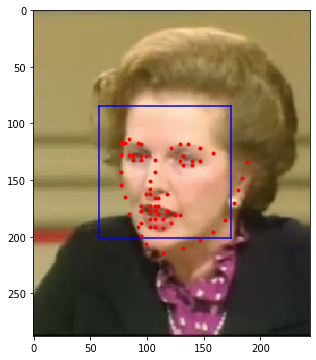

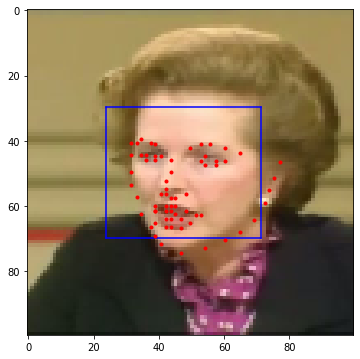

In [39]:
def resize_face_data(im, bounding_box, landmarks2D, new_height = HEIGHT, new_width = WIDTH):
    '''
    Resize input image and update bounding box, landmark coordinates using a new height and width parameters.
    '''
    h, w, _ = im.shape
    scale_x = new_width/w
    scale_y = new_height/h
    return cv2.resize(im, (new_width, new_height)), bounding_box * [scale_x, scale_y], landmarks2D * [scale_x, scale_y]

# the method above can be tested using the code below (change the 'i' variable to your choice)
i = 42
im, bb, lm = load_face_data('Raw', i)
visualize_BB_landmarks(im, bb, lm)
im, bb, lm = resize_face_data(im, bb, lm)
visualize_BB_landmarks(im, bb, lm)

We will parse all the previously saved images, resize them and save the results in a similar folder structure as before. (This will take about 1 hour to finish with $100\times100$ images.)

In [ ]:
#metainfo = read_csv('metainfo.csv')

In [86]:
create_dir_structure('Processed')

with tqdm.tqdm(total=len(metainfo.index)) as pbar:
    for i in range(1, len(metainfo.index)+1):
        im, bb, lm = load_face_data('Raw', i)
        im, bb, lm = resize_face_data(im, bb, lm)
        save_face_data('Processed', im, bb, lm, i)
        pbar.update()
print('Done processing all the images!')

100%|████████████████████████████████| 137382/137382 [1:10:25<00:00, 13.74it/s]


Done processing all the images!


Now the dataset is prepared for training!